In [ ]:
#ADD
import torch, torchvision
import matplotlib.pyplot as plt
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
import multiprocessing
NUM_WORKERS = multiprocessing.cpu_count()
print(NUM_WORKERS)

Tesla T4
2


# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [ ]:
#ADD
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd 'drive/MyDrive/Research Courses/Github'
!ls

/content/drive/MyDrive/Research Courses/Github
2022ML_HW3_Image_Classification.ipynb  lime.ipynb
baseline_40_best.ckpt		       pretrain_40_best.ckpt
baseline_40_log.txt		       pretrain_40_log.txt
food11				       pretrain_best.ckpt


In [ ]:
#! wget https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip
#! wget -O food11.zip "https://github.com/virginiakm1988/ML2022-Spring/blob/main/HW03/food11.zip?raw=true" #corrupted file

In [ ]:
#! unzip -q 'food11.zip' #-q = quiet, or else will output "inflating: training/0_850.jpg" & "inflating: test/850.jpg" etc

# Training

In [ ]:
#_exp_name = "baseline_40"   #pretrained = False,  semi = False
#_exp_name = "pretrain_40"  #pretrained = True,   semi = False
_exp_name = "pseudo_40"    #pretrained = True,   semi = True

In [ ]:
# Import necessary packages.
import numpy as np
import pandas as pd
#import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

#from tqdm.auto import tqdm 
from tqdm import tqdm 
#AssertionError can only test a child process, change 'tqdm.auto' to 'tqdm'
#ref: https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845
import random

In [ ]:
myseed = 6666  
random.seed(myseed) #ADD
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## **Transforms**

In [ ]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


## **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [ ]:
class FoodDataset(Dataset):

    #def __init__(self,path,tfm=test_tfm,files = None):
    def __init__(self,paths,tfm=test_tfm,files = None, label=True): #ADD
        super(FoodDataset).__init__()
        #self.path = path  #ADD
        #self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")]) #ADD
        #            why sort?
        self.files = paths
        if files != None:
            self.files = files
        #print(f"One {path} sample",self.files[0])
        self.transform = tfm
        self.label = label
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label = int(fname.split("/")[-1].split("_")[0]) if self.label else -1
        except:
            label = -1 # test has no label
        return im,label

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, x, y=None, transform=None): 
      self.data = [Image.fromarray(i.cpu().numpy().astype('uint8'), 'RGB') for i in x]
      self.label = y.cpu().numpy()
      self.transform = transform

    def __getitem__(self, idx):
      return self.transform(self.data[idx]), self.label[idx]
        
    def __len__(self):
        return len(self.data)

In [ ]:
_dataset_dir = "./food11"
train_path = os.path.join(_dataset_dir,"training") #9866 items
train_paths = [os.path.join(train_path,x) for x in os.listdir(train_path) if x.endswith(".jpg")]
random.shuffle(train_paths) #DataLoader will also shuffle
label_percent = len(train_paths)//20 #only use 5% of the labels, avg ~40 for each category
print("Num of training samples = ", label_percent)
train_paths_wiflabel = train_paths[:label_percent]
train_paths_nolabel = train_paths[label_percent:]#[:300]

val_path = os.path.join(_dataset_dir,"validation") #3430 items
val_paths = [os.path.join(val_path,x) for x in os.listdir(val_path) if x.endswith(".jpg")]#[:200]

Num of training samples =  493


<BarContainer object of 11 artists>

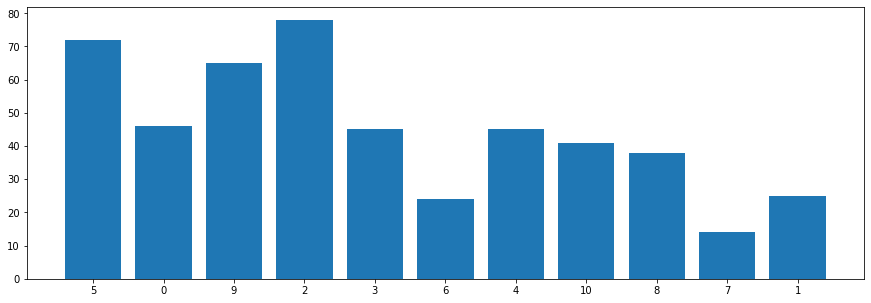

In [ ]:
def label_distrib(paths):
  label_ct_dict = {}
  for fname in paths:
    label = fname.split("/")[-1].split("_")[0]
    label_ct_dict[label] = 1 if (label not in list(label_ct_dict.keys())) else (label_ct_dict[label] + 1)
  return label_ct_dict

diction = label_distrib(train_paths_wiflabel)
plt.figure(figsize=(15,5))
plt.bar(diction.keys(), diction.values())

<BarContainer object of 11 artists>

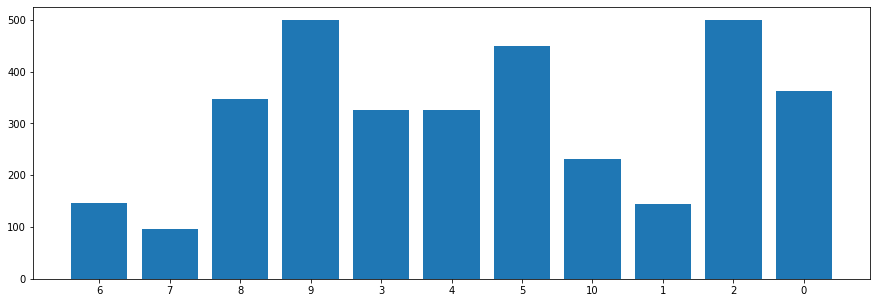

In [ ]:
diction = label_distrib(val_paths)
plt.figure(figsize=(15,5))
plt.bar(diction.keys(), diction.values())

In [ ]:
def get_pseudo_labels(data_loader, model, threshold):
  softmax = nn.Softmax(dim=-1)
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.eval()

  #labelled_x, labelled_y, prob_lst, label_lst = [], [], [], []
  for i, batch in enumerate(tqdm(data_loader)):
    batch = next(iter(data_loader))
    imgs, label = batch
    with torch.no_grad():
      logits = model(imgs.to(device))
    probs = softmax(logits) #[64, 11]
    #prob, pred = np.amax(probs, axis=-1), np.argmax(probs, axis=-1) #shape = (64,)
    prob, pred = torch.max(probs, dim=1)
    prob, pred = prob.cpu(), pred.cpu()
    imgs, label = imgs.cpu(), label.cpu()

    idxs = torch.where((prob>threshold[0]) & (prob < threshold[1]))[0]
    #https://stackoverflow.com/questions/67163825/the-truth-value-of-an-array-with-more-than-one-element-is-ambiguous-error-pyt
    #all_lst = np.array([[imgs.cpu()[i], label.cpu()[i], prob[i], pred[i]] for i in idxs]) #list comprehension
    
    #https://discuss.pytorch.org/t/pytorch-equivalent-of-numpy-take/108797/2
    labelled_x = torch.index_select(imgs,0,idxs) if i==0 else torch.cat((labelled_x, torch.index_select(imgs,0,idxs)))
    labelled_y = torch.index_select(label,0,idxs) if i==0 else torch.cat((labelled_y, torch.index_select(label,0,idxs)))
    prob_arr = torch.index_select(prob,0,idxs) if i==0 else torch.cat((prob_arr, torch.index_select(prob,0,idxs)))
    pred_arr = torch.index_select(pred,0,idxs) if i==0 else torch.cat((pred_arr, torch.index_select(pred,0,idxs)))
    #pred_arr = np.take(pred, idxs, axis=0) if i==0 else torch.cat((pred_arr, np.take(pred, idxs, axis=0)))

  labelled_x, pred_arr = labelled_x[:label_percent//2], pred_arr[:label_percent//2]
  print("labelled_x.shape = ", labelled_x.shape)
  print("pred_lst.shape = ", pred_arr.shape)
  print("[Info] " + str(labelled_x.shape[0]) + " imgs added as pseudo label")

  ds = CreateDataset(labelled_x, pred_arr, transform=train_tfm) #use predicted labels as pseudo
  view_img(labelled_x.cpu().numpy(), labelled_y.cpu().numpy(), 
           prob_arr.cpu().numpy(), pred_arr.cpu().numpy())
  # Turn off eval mode
  model.train()
  return ds

In [ ]:
batch_size = 64 #Greater batch size --> more stable gradient.
semi = True
#_dataset_dir = "./food11"
# The argument "loader" tells how torchvision reads the data.
#train_set = FoodDataset(os.path.join(_dataset_dir,"training"), tfm=train_tfm)
train_set = FoodDataset(train_paths_wiflabel, tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
if semi:
  train_nolbl_set = FoodDataset(train_paths_nolabel, tfm=train_tfm) #still include labels for visualization, but will remove it in get_pseudo_labels()
  train_nolbl_loader = DataLoader(train_nolbl_set, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
#valid_set = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=test_tfm)
valid_set = FoodDataset(val_paths, tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
class_names = {0:'Bread', 1:'Dairy product', 2:'Dessert', 3:'Egg', 4:'Fried food', 5:'Meat', 6:'Noodles/Pasta', 7:'Rice', 8:'Seafood', 9:'Soup', 10:'Vegetable/Fruit'}

In [ ]:
from skimage.segmentation import slic
!pip install lime==0.1.1.37
from lime import lime_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # pytorch tensor, (batches, channels, height, width)
    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # split the image into 200 pieces with the help of segmentaion from skimage                                                                                                                   
    return slic(input, n_segments=200, compactness=1, sigma=1, start_label=1) 


def view_img(images, labels, prob=None, pred=None):
    #std = np.array([0.2708, 0.2733, 0.2718])
    #mean = np.array([0.5462, 0.4369, 0.3265])
    plt.figure(figsize=(30, 15))
    for i in range(min(32, int(images.shape[0]))): # show at most 32 images
      ax = plt.subplot(4, 8, i + 1)
      ax.axis('off') # turn axis off for each subplot
      try:
        inp = images[i].numpy()
      except:
        inp = images[i]
    
      #inp = np.array([inp[i]*std[i] + mean[i] for i in range(3)]) 
      inp = inp.transpose((1, 2, 0))

      #lime: Green --> positive correlation; Red --> negative correlation
      explainer = lime_image.LimeImageExplainer()                                                                                                                              
      explaination = explainer.explain_instance(
          image=inp.astype(np.double), classifier_fn=predict, segmentation_fn=segmentation, top_labels=11)
      # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance
      #print(int(labels[i]))
      lime_img, mask = explaination.get_image_and_mask(
          label=int(labels[i]), positive_only=False, hide_rest=False, num_features=11, min_weight=0.05) #label=label.item()

      #plt.imshow(np.clip(inp, 0, 1))
      #plt.imshow(inp)
      plt.imshow(lime_img)

      txt = str(int(labels[i])) + '_' + class_names[int(labels[i])]
      color = 'black'
      if np.array(prob).all():
        txt += '\n{:.2f}%'.format(float(prob[i])*100) + ' ' + class_names[int(pred[i])]
        color = 'green' if (int(labels[i])==int(pred[i])) else 'red'

      plt.title(txt, color=color)
      #plt.axis("off")
    plt.show()

In [ ]:
#images, labels = next(iter(train_loader))
#print(images.shape,labels.shape) #torch.Size([64, 3, 128, 128]) torch.Size([64])
#view_img(images, labels)

Ori:
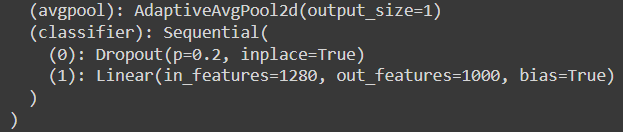

In [ ]:
#class Classifier(nn.Module):

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#model = Classifier().to(device) # Initialize model.
#model = torchvision.models.resnext101_32x8d(pretrained=False).to(device)   # Num Params =  88791336
model = torchvision.models.efficientnet_v2_s(pretrained=True)#.to(device)  # Num Params =  21458488
#print(model.classifier) #https://discuss.pytorch.org/t/finetuning-efficientnet-in-pytorch/89852
#[[name, module] for name, module in model.named_modules()] #https://discuss.pytorch.org/t/how-to-get-the-module-names-of-nn-sequential/39682
#model = nn.Sequential(model, nn.Linear(model.fc.in_features, 11)) #add layer
#model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(1280, 11)) #replace layer 
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 11) #https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
model = model.to(device)
#print(model)
print('Num Params = ', sum(p.numel() for p in model.parameters() if p.requires_grad)) 
#default: all of the parameters have .requires_grad=True

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Num Params =  20191579


In [ ]:
n_epochs = 400
patience = 3 # If no improvement in 'patience' epochs, early stop


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 

stale, best_acc, improvement, prev_val_acc, semi_ct = 0, 0, 100., 0., 0
for epoch in range(n_epochs):

    if semi and improvement < 2.0*(1/(semi_ct+1)) and improvement > -3.:
      semi_ct += 1
      prev_val_acc = 0. #wait 1 ep for semi
      print("improvement = {:.6f}%".format(improvement))
      pseudo_set = get_pseudo_labels(train_nolbl_loader, model, threshold=[0.85, 0.999])
      concat_dataset = ConcatDataset([train_set, pseudo_set])
      train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

    # ---------- Training ----------
    model.train()
    train_loss, train_accs = [], []
    for batch in tqdm(train_loader):
        imgs, labels = batch
        logits = model(imgs.to(device)) # Forward the data. (Make sure data and model are on the same device.)
        loss = criterion(logits, labels.to(device)) #softmax calculated automatically

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        loss.backward() #compute grad for params
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10) # Clip the gradient norms for stable training.
        optimizer.step() # Update the parameters with computed gradients.

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    #print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    model.eval() # Make sure the model is in eval mode so that some modules like dropout are disabled 
    valid_loss, valid_accs = [], []
    for batch in tqdm(valid_loader):
        imgs, labels = batch
        #imgs = imgs.half()
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    #print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    #with open(f"./{_exp_name}_log.txt","a"):
    out = "[{:03d}/{:03d}] train_loss: {:.3f}, train_acc: {:3.2f}% | val_loss: {:.3f}, val_acc: {:3.2f}%".format(
          epoch + 1, n_epochs, train_loss, train_acc*100, valid_loss, valid_acc*100)
    print(out)
    with open(f"./{_exp_name}_log.txt","a") as f:
      print(out, file=f)
    
    #for pseudo
    improvement = valid_acc*100 - prev_val_acc
    prev_val_acc = valid_acc*100
    """
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    """
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale >= patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break
    print("")

In [ ]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
#model = torchvision.models.efficientnet_v2_s(pretrained=False).to(device)
model_best = model#Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()

softmax = nn.Softmax(dim=-1)
imgs, labels = next(iter(valid_loader))
with torch.no_grad():
    logits = model(imgs.to(device))
probs = softmax(logits)
prob, pred = torch.max(probs, dim=1)
probs.shape
view_img(imgs.cpu(), labels.cpu(), prob.cpu(), pred.cpu())


# Testing and generate prediction CSV

In [ ]:
"""
test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
"""

'\ntest_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=test_tfm)\ntest_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)\n'

In [ ]:
"""
model_best = torchvision.models.resnext101_32x8d(pretrained=False).to(device)#Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in test_loader:
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()
"""

'\nmodel_best = torchvision.models.resnext101_32x8d(pretrained=False).to(device)#Classifier().to(device)\nmodel_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))\nmodel_best.eval()\nprediction = []\nwith torch.no_grad():\n    for data,_ in test_loader:\n        test_pred = model_best(data.to(device))\n        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)\n        prediction += test_label.squeeze().tolist()\n'

## References
[1] https://www.kaggle.com/c/ml2022spring-hw3b/code?competitionId=34954&sortBy=dateCreated (We strongly recommend that you run with Kaggle for this homework (HW3))

[2] https://colab.research.google.com/drive/15hMu9YiYjE_6HY99UXon2vKGk2KwugWu
